<a href="https://colab.research.google.com/github/isoittech/SAMPLE_WEB_pytorch_lstm/blob/master/mk_pytorch02_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

PyTorchを使ってLSTMで文章分類を実装してみた。  
前の版ではPytorchでLSTMを使って文章分類（ニュース記事のタイトルのカテゴリ分類）を実装しました。  
その際、バッチ化はひとまず置いといて（バッチサイズ=1）で実装していましたが、今回はバッチ化対応した。

https://qiita.com/m__k/items/db1a81bb06607d5b0ec5

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import linecache
from IPython.display import Image
import re

try:
    try:
        import MeCab
    except ImportError:
        # MeCabをcolabで使えるようにする
        !apt install aptitude
        !aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
        !pip install mecab-python3
        import MeCab # 再挑戦
except ImportError as e:
  print('Mecab import error')
  print(e)



# データ準備とバッチ化
LSTMのインプットの形式は前回の記事でも言及したように文章の長さ × バッチサイズ × ベクトル次元数の３次元テンソルでした。

実際のデータ（ニュース記事のタイトル）の長さ（厳密には形態素の数）は異なりますが、データをバッチ化してまとめてLSTMに流すために文章の系列の長さを揃える必要があります。

系列の長さを揃えるために単語リストに新しく<pad>（単語ID＝0）を追加して短い文章を0パディングします。
詳細はソースコードを見たほうがわかりやすいと思うので、いきなり全ソースを載せつつ、前回の記事と比べてバッチ化対応するために変更した部分に言及してきます。

In [2]:
if os.path.exists('text'):
  print('Directory text exists.')
else:
  try:
    try:
      from google.colab import drive
      drive.mount(r'/content/drive')
      !ln -s /usr/local/etc/mecabrc /etc/mecabrc
      %cd '/content/drive/MyDrive/Colab Notebooks/SAMPLES/pytorch_lstm'
      %pwd
      # %ls
      !tar xvf ldcc-20140209.tar.gz
      %ls

    except Exception as e1:
      print('Maybe you not Google Colab.')
      print(e1)

  except Exception as e2:
    print('Error')
    print(e2)

Directory text exists.


In [3]:
# カテゴリを配列で取得
categories = [name for name in os.listdir("text") if os.path.isdir("text/" + name)]
print(categories)

['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']


In [4]:
datasets = pd.DataFrame(columns=["title", "category"])
print(f"type: ${type(datasets)}")
print(f"shape: ${datasets.shape}")
datasets

type: $<class 'pandas.core.frame.DataFrame'>
shape: $(0, 2)


,title,category


In [5]:
for cat in categories:
    path = "text/" + cat + "/*.txt"
    files = glob(path)
    for text_name in files:
        title = linecache.getline(text_name, 3)
        s = pd.Series([title, cat], index=datasets.columns)
        datasets = datasets.append(s, ignore_index=True)

print(f"type: ${type(datasets)}")
print(f"shape: ${datasets.shape}")
datasets

type: $<class 'pandas.core.frame.DataFrame'>
shape: $(7376, 2)


,title,category
0,友人代表のスピーチ、独女はどうこなしている？\n,dokujo-tsushin
1,ネットで断ち切れない元カレとの縁\n,dokujo-tsushin
2,相次ぐ芸能人の“すっぴん”披露 その時、独女の心境は？\n,dokujo-tsushin
3,ムダな抵抗！？ 加齢の現実\n,dokujo-tsushin
4,税金を払うのは私たちなんですけど！\n,dokujo-tsushin
...,...,...
7371,爆笑問題・田中裕二も驚く「ひるおび!」での恵俊彰の“天然”ぶり\n,topic-news
7372,黒田勇樹のDV騒動 ネット掲示板では冷ややかな声も\n,topic-news
7373,サムスンのアンドロイド搭載カメラが韓国で話題に\n,topic-news
7374,米紙も注目したゲーム「竹島争奪戦」\n,topic-news


## 形態素解析エンジン定義


In [6]:
tagger = MeCab.Tagger("-Owakati")

def make_wakati(sentence):
    sentence = tagger.parse(sentence)
    sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
    sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
    wakati = sentence.split(" ")
    wakati = list(filter(("").__ne__, wakati))
    return wakati

## 単語IDの辞書を定義
単語IDの辞書に新しく\<pad\>を追加

In [7]:
word2index = {}
# 系列を揃えるためのパディング文字列<pad>を追加
# パディング文字列のIDは0とする
word2index.update({"<pad>":0})

for title in datasets["title"]:
    wakati = make_wakati(title)
    for word in wakati:
        if word in word2index: continue
        word2index[word] = len(word2index)
print("vocab size : ", len(word2index))

vocab size :  13277


## 系列の長さを揃えてバッチでまとめる


In [8]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

cat2index = {}
for cat in categories:
    if cat in cat2index: continue
    cat2index[cat] = len(cat2index)
    
cat2index

{'dokujo-tsushin': 0,
 'it-life-hack': 1,
 'kaden-channel': 2,
 'livedoor-homme': 3,
 'movie-enter': 4,
 'peachy': 5,
 'smax': 6,
 'sports-watch': 7,
 'topic-news': 8}

In [9]:
def sentence2index(sentence):
    wakati = make_wakati(sentence)
    return [word2index[w] for w in wakati]

def category2index(cat):
    return [cat2index[cat]]

In [10]:
index_datasets_title_tmp = []
index_datasets_category = []

# 系列の長さの最大値を取得。この長さに他の系列の長さをあわせる
max_len = 0
for title, category in zip(datasets["title"], datasets["category"]):
  index_title = sentence2index(title)
  index_category = category2index(category)
  index_datasets_title_tmp.append(index_title)
  index_datasets_category.append(index_category)
  if max_len < len(index_title):
    max_len = len(index_title)

print(type(index_datasets_title_tmp))
index_datasets_title_tmp[:10]

<class 'list'>


[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 3, 19],
 [20, 21, 3, 22, 23, 24, 25, 5, 6, 3, 26, 7],
 [27, 28, 29, 30, 31, 3, 32],
 [33, 34, 35, 3, 7, 36, 37, 28, 38, 39, 40],
 [41, 13, 42, 43, 10, 42, 44, 3, 45, 34, 46, 47, 3, 48],
 [44, 49, 50, 10, 51, 52, 53, 15, 54, 55, 56, 57],
 [58, 53, 10, 51, 59, 3, 7, 60, 61, 45, 3, 62],
 [54, 63, 49, 64, 65, 66, 67, 68, 69, 49, 70, 5, 6, 3, 71, 3, 72, 18, 7],
 [73, 74, 13, 75, 76, 77, 68, 78, 79, 80, 81]]

In [11]:
max_len

38

In [12]:
print(type(index_datasets_category))
index_datasets_category[:10]

<class 'list'>


[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]

In [13]:
# 系列の長さを揃えるために短い系列にパディングを追加
# 後ろパディングだと正しく学習できなかったので、前パディング
index_datasets_title = []
for title in index_datasets_title_tmp:
  for i in range(max_len - len(title)):
    title.insert(0, 0) # 前パディング
#     title.append(0)　# 後ろパディング
  index_datasets_title.append(title)

print(type(index_datasets_title))
index_datasets_title[:3]

<class 'list'>


[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  3,
  19],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  20,
  21,
  3,
  22,
  23,
  24,
  25,
  5,
  6,
  3,
  26,
  7]]

In [14]:
train_x, test_x, train_y, test_y = train_test_split(index_datasets_title, index_datasets_category, train_size=0.7)


In [15]:
# データをバッチでまとめるための関数
def train2batch(title, category, batch_size=100):
  title_batch = []
  category_batch = []
  title_shuffle, category_shuffle = shuffle(title, category)
  for i in range(0, len(title), batch_size):
    title_batch.append(title_shuffle[i:i+batch_size])
    category_batch.append(category_shuffle[i:i+batch_size])
  return title_batch, category_batch

## モデル定義
パディング文字列ももちろん埋め込む必要があるわけですが、\<pad>は0ベクトルで埋め込み、学習の妨げにならないようにする(?)ために、nn.Embedding()にてpadding_idx=0を追加しています。
LSTMを定義する際、batch_first=Trueを指定すると、LSTMのインプットの形式がバッチサイズ × 文章の長さ × ベクトル次元数になります。こうしたほうが次元を操作する際にわかりやすいと思います。

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# GPUを使うために必要
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [17]:
test_x = torch.zeros(2, 1, 3)
print(test_x.size())
test_x

torch.Size([2, 1, 3])


tensor([[[0., 0., 0.]],

        [[0., 0., 0.]]])

In [18]:
test_y = torch.squeeze(test_x)
print(test_y.size())
test_y

torch.Size([2, 3])


tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [19]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        # <pad>の単語IDが0なので、padding_idx=0としている
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # batch_first=Trueが大事！
        # batch_first=Trueを指定すると、LSTMのインプットの形式がバッチサイズ × 文章の長さ(vocab_size) × ベクトル次元数(embedding_dim)になる
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.LogSoftmax()

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        # embeds.size() => (batch_size × len(sentence) × embedding_dim)
        _, lstm_out = self.lstm(embeds)
        # lstm_out[0].size() => (1 × batch_size × hidden_dim)
        # lstm_outには2個の要素がある。1つ目が最後の隠れ層の隠れ状態h、2つ目が最後の隠れ層のセル状態c。
        # many to one パターンであるため、最後の隠れ層の隠れ状態しか使わないので、lstm_out[0]のみを使う（結合層に渡す）。
        tag_space = self.hidden2tag(lstm_out[0])
        # tag_space.size() => (1 × batch_size × tagset_size)
        # (batch_size × tagset_size)にするためにsqueeze()してから（次元を落としてから）、softmax関数にかける。
        # https://pytorch.org/docs/stable/generated/torch.squeeze.html
        tag_scores = self.softmax(tag_space.squeeze())
        # tag_scores.size() = (batch_size × tagset_size)ｈ

        return tag_scores

In [20]:
# 単語の埋め込み次元数上げた。精度がそこそこアップ！ハイパーパラメータのチューニング大事。
EMBEDDING_DIM = 200
HIDDEN_DIM = 128
VOCAB_SIZE = len(word2index)
TAG_SIZE = len(categories)
# to(device)でモデルがGPU対応する
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAG_SIZE).to(device)
loss_function = nn.NLLLoss()
# SGDからAdamに変更。特に意味はなし
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 学習
1epoch毎に全バッチを学習させます。バッチごとに逆伝搬してパラメータ更新させてます。

In [21]:
losses = []
for epoch in range(100):
    all_loss = 0
    title_batch, category_batch = train2batch(train_x, train_y)
    for i in range(len(title_batch)):
        batch_loss = 0

        model.zero_grad()

        # 順伝搬させるtensorはGPUで処理させるためdevice=にGPUをセット
        title_tensor = torch.tensor(title_batch[i], device=device)
        # category_tensor.size() = (batch_size × 1)なので、squeeze()
        category_tensor = torch.tensor(category_batch[i], device=device).squeeze()

        out = model(title_tensor)

        batch_loss = loss_function(out, category_tensor)
        batch_loss.backward()
        optimizer.step()

        all_loss += batch_loss.item()
    losses.append(all_loss)
    print("epoch", epoch, "\t" , "loss", all_loss)
    if all_loss < 0.1: break
print("done.")

<ipython-input-19-8fa141d15f80>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  tag_scores = self.softmax(tag_space.squeeze())


epoch 0 	 loss 93.56144726276398
epoch 1 	 loss 62.2303067445755
epoch 2 	 loss 43.7643187046051
epoch 3 	 loss 28.969568729400635
epoch 4 	 loss 18.25108914077282
epoch 5 	 loss 10.427849754691124
epoch 6 	 loss 5.568141933530569
epoch 7 	 loss 2.972314717248082
epoch 8 	 loss 1.6831649839878082
epoch 9 	 loss 1.037938660942018
epoch 10 	 loss 0.7133718775585294
epoch 11 	 loss 0.5359514066949487
epoch 12 	 loss 0.43793526687659323
epoch 13 	 loss 0.36475584493018687
epoch 14 	 loss 0.3218360096216202
epoch 15 	 loss 0.32037559687159956
epoch 16 	 loss 0.2685911732260138
epoch 17 	 loss 0.24653033900540322
epoch 18 	 loss 0.22653803450521082
epoch 19 	 loss 0.21270875295158476
epoch 20 	 loss 0.21001775737386197
epoch 21 	 loss 0.19516369746997952
epoch 22 	 loss 0.18627238902263343
epoch 23 	 loss 0.1825403090333566
epoch 24 	 loss 0.17467990354634821
epoch 25 	 loss 0.17094042181270197
epoch 26 	 loss 0.16930701828096062
epoch 27 	 loss 0.16362492967164144
epoch 28 	 loss 0.15913833

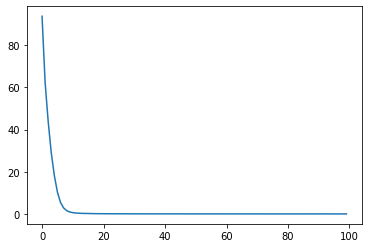

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)

## 予測
バッチ毎にまとめて予測。
前回と比べて精度が上がっているのは単語の埋め込み次元数を上げたからだと思われます。

In [23]:
test_num = len(test_x)
a = 0
with torch.no_grad():
    title_batch, category_batch = train2batch(test_x, test_y)

    for i in range(len(title_batch)):
        title_tensor = torch.tensor(title_batch[i], device=device)
        category_tensor = torch.tensor(category_batch[i], device=device)

        out = model(title_tensor)
        _, predicts = torch.max(out, 1)
        for j, ans in enumerate(category_tensor):
            if predicts[j].item() == ans.item():
                a += 1
print("predict : ", a / test_num)

<ipython-input-23-f4958859d2b4>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  title_tensor = torch.tensor(title_batch[i], device=device)
<ipython-input-23-f4958859d2b4>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  category_tensor = torch.tensor(category_batch[i], device=device)


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

## 最後に
バッチ化対応の一番苦労したところはやはり次元の扱いでした。私と同じように次元数によるエラーで躓いている方は、全てのtensorの次元を逐一確認して、データの形状を細かく追ってみるのがよいと思います。